<a href="https://colab.research.google.com/github/KarthiK2601/ViT/blob/main/MAE_ViT_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [1]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 4.7 MB/s eta 0:00:00
Cloning into 'mae'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39
Receiving objects: 100% (39/39), 829.54 KiB | 9.99 MiB/s, done.
Resolving deltas: 100% (12/12), done.


### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

### Load an image

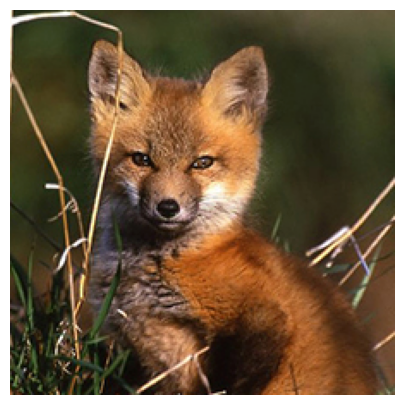

In [4]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = Image.open(requests.get(img_url, stream=True).raw)
img = img.resize((224, 224))
img = np.array(img) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [5]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


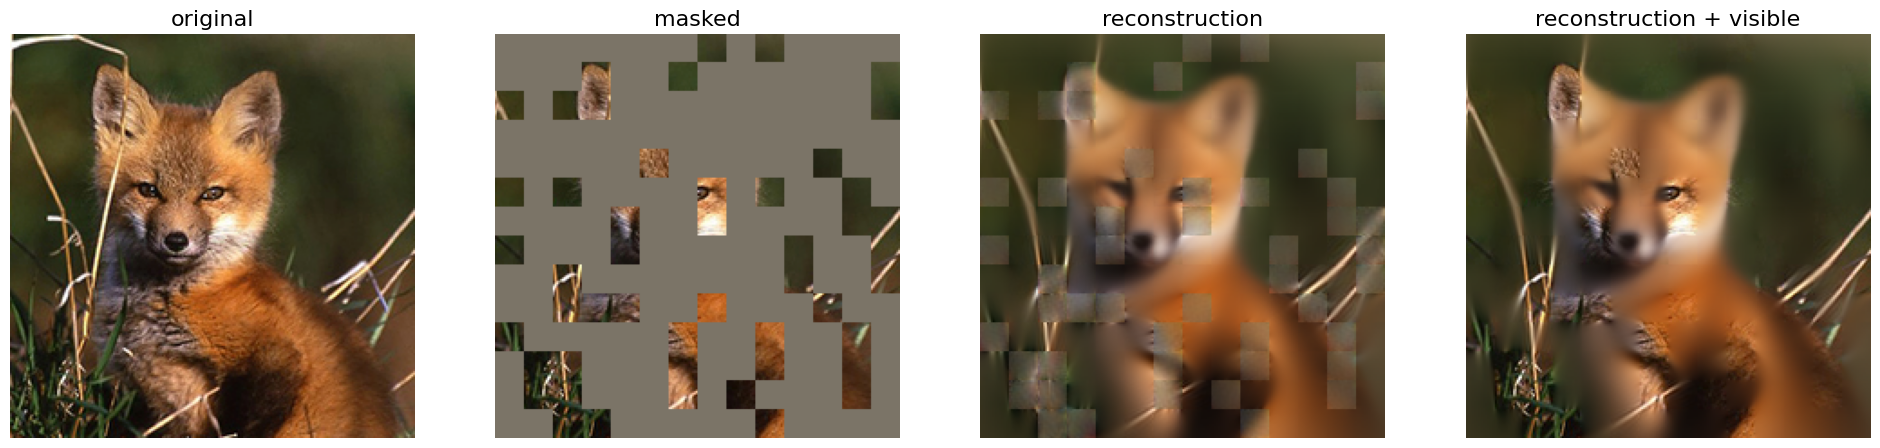

In [6]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

### Load another pre-trained MAE model

In [ ]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:


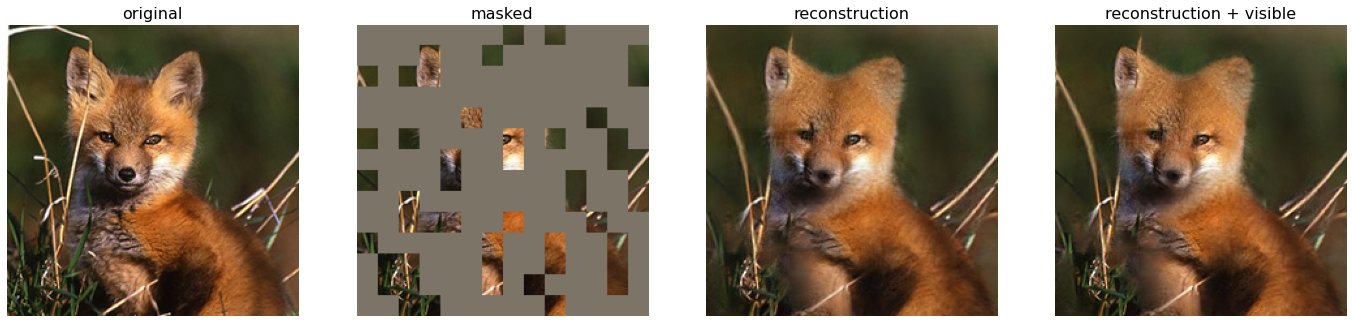

In [ ]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

In [3]:
def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=7, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

In [10]:
'''def mae_vit_mnist_patch4_dec28d6b(**kwargs):
    model = MaskedAutoencoderViT(
        img_size=28,  # Update the image size
        patch_size=4,  # Reduce the patch size for smaller images
        embed_dim=256,  # Decrease the embedding dimension for smaller images
        depth=6,  # Decrease the number of layers for faster training on smaller images
        num_heads=8,  # Decrease the number of heads for smaller images
        decoder_embed_dim=64,  # Decrease the decoder embedding dimension
        decoder_depth=6,  # Decrease the number of decoder layers
        decoder_num_heads=8,  # Decrease the number of decoder heads
        mlp_ratio=4,
        norm_layer=partial(nn.LayerNorm, eps=1e-6),
        **kwargs
    )
    return model


In [4]:
from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

from util.pos_embed import get_2d_sincos_pos_embed

In [5]:
class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Import your MaskedAutoencoderViT model and the factory function (mae_vit_base_patch16_dec512d8b) here
# Replace <path_to_your_model> with the actual path where the model class and factory function are defined
#from <path_to_your_model> import MaskedAutoencoderViT, mae_vit_base_patch16_dec512d8b

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# MNIST data transformations with resizing and RGB conversion
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 to match the model's input size
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel (RGB)
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 80212748.24it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 49182173.70it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20003561.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5396750.36it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [12]:
import time
# Initialize the MAE-ViT model with desired configuration
model = mae_vit_base_patch16_dec512d8b().to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 1

for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_idx, (images, _) in enumerate(train_loader, 1):
        start = time.time()
        images = images.to(device)

        # Forward pass
        loss, _, _ = model(images)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        end = time.time()
        print(f"for iteration " , batch_idx , " total time : " , end - start)

        # Print training progress
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
            break

    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {total_loss / len(train_loader):.4f}")



for iteration  1  total time :  35.83160591125488
for iteration  2  total time :  43.695268869400024
for iteration  3  total time :  37.00487446784973
for iteration  4  total time :  36.25668978691101
for iteration  5  total time :  36.774630546569824
for iteration  6  total time :  36.949411153793335
for iteration  7  total time :  37.04600167274475
for iteration  8  total time :  39.55048871040344
for iteration  9  total time :  35.96687436103821
for iteration  10  total time :  36.80444359779358
for iteration  11  total time :  36.878374338150024
for iteration  12  total time :  37.043976068496704
for iteration  13  total time :  36.90162920951843
for iteration  14  total time :  35.79093337059021
for iteration  15  total time :  36.60043954849243
for iteration  16  total time :  37.008209466934204
for iteration  17  total time :  36.79841589927673
for iteration  18  total time :  39.96290421485901
for iteration  19  total time :  37.969926595687866
for iteration  20  total time :  

In [8]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/MAE_files/")

Mounted at /content/drive


In [15]:
torch.save(model.state_dict(), '/content/drive/My Drive/MAE_files/modelMAE01.pth')

In [5]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from functools import partial

import torch
import torch.nn as nn

#from timm.models.vision_transformer import PatchEmbed, Block

#from util.pos_embed import get_2d_sincos_pos_embed

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time

In [9]:
state_dict = torch.load('/content/drive/My Drive/MAE_files/modelMAE01.pth')
print(state_dict.keys())


odict_keys(['cls_token', 'pos_embed', 'mask_token', 'decoder_pos_embed', 'patch_embed.proj.weight', 'patch_embed.proj.bias', 'blocks.0.norm1.weight', 'blocks.0.norm1.bias', 'blocks.0.attn.qkv.weight', 'blocks.0.attn.qkv.bias', 'blocks.0.attn.proj.weight', 'blocks.0.attn.proj.bias', 'blocks.0.norm2.weight', 'blocks.0.norm2.bias', 'blocks.0.mlp.fc1.weight', 'blocks.0.mlp.fc1.bias', 'blocks.0.mlp.fc2.weight', 'blocks.0.mlp.fc2.bias', 'blocks.1.norm1.weight', 'blocks.1.norm1.bias', 'blocks.1.attn.qkv.weight', 'blocks.1.attn.qkv.bias', 'blocks.1.attn.proj.weight', 'blocks.1.attn.proj.bias', 'blocks.1.norm2.weight', 'blocks.1.norm2.bias', 'blocks.1.mlp.fc1.weight', 'blocks.1.mlp.fc1.bias', 'blocks.1.mlp.fc2.weight', 'blocks.1.mlp.fc2.bias', 'blocks.2.norm1.weight', 'blocks.2.norm1.bias', 'blocks.2.attn.qkv.weight', 'blocks.2.attn.qkv.bias', 'blocks.2.attn.proj.weight', 'blocks.2.attn.proj.bias', 'blocks.2.norm2.weight', 'blocks.2.norm2.bias', 'blocks.2.mlp.fc1.weight', 'blocks.2.mlp.fc1.bias

In [10]:
model = mae_vit_base_patch16_dec512d8b().to(device)

model.load_state_dict(state_dict)

<All keys matched successfully>

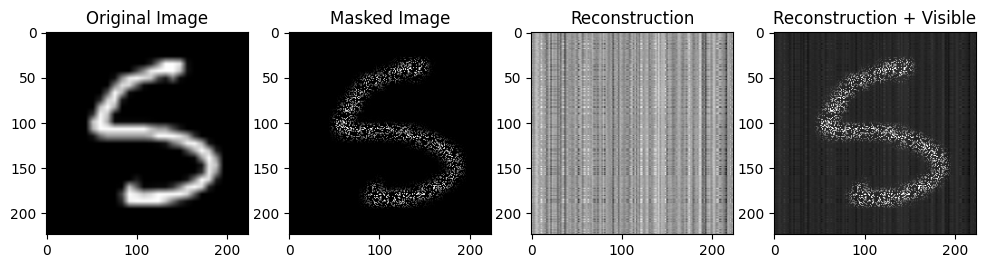

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Function to apply mask on an image
def apply_mask(image, mask_ratio):
    num_pixels_to_mask = int(image.size(2) * image.size(3) * mask_ratio)
    mask_indices = np.random.choice(image.size(2) * image.size(3), num_pixels_to_mask, replace=False)
    image[:, :, mask_indices // image.size(3), mask_indices % image.size(3)] = 0.0
    return image

# Sample a random image from the MNIST dataset
sample_image, _ = train_dataset[np.random.randint(len(train_dataset))]
sample_image = sample_image.unsqueeze(0).to(device)

# Mask the image
masked_image = apply_mask(sample_image.clone(), mask_ratio=0.75)
masked_image_np = masked_image.squeeze().cpu().numpy()

# Get the reconstruction from the model
with torch.no_grad():
    model.eval()
    _, reconstructed_image, _ = model(masked_image)  # Output already has the same dimensions as the input

# Convert the reconstructed_image to a numpy array and resize it to match masked_image_np
reconstructed_image_np = reconstructed_image.squeeze().cpu().numpy()
reconstructed_image_np = F.interpolate(torch.tensor(reconstructed_image_np[np.newaxis, np.newaxis]), size=(masked_image_np.shape[1], masked_image_np.shape[2]), mode='bilinear').squeeze().numpy()

# Perform the addition
combined_image_np = masked_image_np + reconstructed_image_np

# Plot the original, masked, reconstructed, and combined images
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(sample_image.squeeze().cpu().numpy().transpose(1, 2, 0), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 4, 2)
plt.imshow(masked_image_np.transpose(1, 2, 0), cmap='gray')
plt.title('Masked Image')

plt.subplot(1, 4, 3)
plt.imshow(reconstructed_image_np, cmap='gray')
plt.title('Reconstruction')

plt.subplot(1, 4, 4)
plt.imshow(combined_image_np.transpose(1, 2, 0), cmap='gray')
plt.title('Reconstruction + Visible')

plt.show()


In [36]:
print(type(pred))
print(pred.size())


print(type(sample_image))
print(sample_image.size())


#print(type(something1))
#print(something1.size())

#print(type(something2))
#print(something2.size())

<class 'torch.Tensor'>
torch.Size([1, 1024, 147])
<class 'torch.Tensor'>
torch.Size([1, 3, 224, 224])
